Lesson adapted from Aymeric Damian's excellent [Tensorflow tutorials](https://github.com/aymericdamien/TensorFlow-Examples).

# Convolutional Neural Networks Using Estimators 

<center>![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)</center>

Parameters for our CNN

In [1]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
## Tensorflow produces a lot of warnings. We generally want to suppress them. The below code does exactly that. 
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

## Strategy

**Step 1** - Implement a ConvNet function using Layers API

**Step 2** - Define model in terms of ConvNet function and input_fn


**Step 3** - Build Estimator

**Step 4** - Train, Evaluate, Predict

 ## ConvNet Function

Input: 
- x_dict -- dict
- n_classes -- int
- dropout -- boolean
- reuse -- boolean
- is_training -- boolean

Output: logits -- array of `n_classes` logits

### Dropout 

<font color="blue">What is dropout?</font>

Dropout is a technique developed in 2014 to "learn better by learning less". A dropout layer between two Dense layers would not permit the forward or backward flow of information with a pre-defined probability at training time. In other words, Dropout randomly drops neural units in the layers that sandwich the Dropout layer during training. The learned wisdom behind Dropout is that it aids in regularization by forcing the Neural network to learn without overfitting.

- Randomly drop neurons in layers surrounding a dropout layer when training

- Aids in regularization by forcing NN to learn without overfitting

<center><img src="img/Dropout.png" alt="nn" style="width: 400px;"/>
Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014</center>

#### Training and Testing with Dropout

- Different DataFlow Graph for Training and Testing

- Retain all weights learned during Training 

- Use all neurons while Testing

At test time, all neurons in the network are active. So the computational graph varies between the training and testing phase, however the weights applied at each neuron remain the same. 


- Inbuilt TensorFlow support for Dropout -- `reuse` flag in `variable_scope`:
```
with tf.variable_scope('ConvNet', reuse=reuse):
```

Usually, each call to a model creating function, creates a new tensorflow graph. The `reuse` flag prevents this in the variable's scope and reuses all variables in that scope if already present in a tensorflow graph.

- Resize Input to match picture format
- Picture format = 28 x 28, 1 channel

```python
#If a component of shape is =1, the size of that dimension is computed so total size remains constant
x = tf.reshape(x, shape=[-1, 28, 28, 1])
```

Our input tensor has the shape `784 x batch_size`.

We should reshape the input tensor so that the ConvNet can learn filters that are spatially aware. We'll reshape this input tensor to match the picture's format: `Height x Width x Channel`.

```x = tf.reshape(x, shape=[-1, 28, 28, 1])```
 
Tensor input is now 4-D: `Batch Size, Height, Width, Channel`



### Convolution and Pooling

<center><img src="img/convolutional_neural_network.png" alt="nn" style="width: 700px;"/></center>

**2D Convolution**

- Element wise multiplication of 2D filter as it slides across the length and breadth of input image  

|    |   |   |
|:---:|:---:|:---:|
| -5 | 0 | 0 | 
|  0 | 0 | 0 |
|  0 | 0 | 5 |

* Convolution with Diagonal edge detector:
<center><img src="img/edge.jpg" alt="nn" style="width: 700px;"/></center>

```python
conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
```

**2D Max Pooling**
<center><img src="img/pool.png" alt="nn" style="width: 600px;"/></center>
- Reduce the spatial size of input by subsampling every `n x n` slice of a Convolved 2D Tensor 
- Replace each slice with max value in the slice

```python
conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
```

ConvNets are built using the fundamental operations of Convolution and Pooling.

The 2D Convolution operation takes a large input 2D Tensor and multiplies each element, the weight, in a smaller 2D window, canonically called the Convolutional Filter.

The Pooling operation's function is to reduce the spatial size of the input image, reducing the number of parameters and avoiding overfitting. The most commonly used Pooling operation for images is a 2D MAX Pooling operation that downsamples every `n x n` slice of the Convolved Tensor by replacing the slice with the Maximum value in the `n x n` slice.

For a more detailed, but probably the clearest writing about ConvNets, check out Andrej Karpathy's CSE231n lesson notes about the layers in ConvNets: http://cs231n.github.io/convolutional-networks/#pool   

TensorFlow provides support for Convolution and Pooling through the Layers API

- Convolution:
```
conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
```
Specifies a Convolutional layer with 32 filters, and shape `5 x 5`

- Pooling:
```
conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
```
Specifies a Max Pooling layer with a stride of 2, and shape `2 x 2`

Next, we need to flatten the convolved and downsampled image into a 1 dimensional Tensor so that we can pass it through Dense layers and output an array of 10 logits.

```python
fc1 = tf.contrib.layers.flatten(conv2)
```

Lastly, we add Dense layers that sandwich a Dropout layer
```python
fc1 = tf.layers.dense(fc1, 1024)
fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
out = tf.layers.dense(fc1, n_classes)
```

The `training` flag in the Dropout layer is a toggle to enable the layer when we are Training the model, and disable it at test time.

Putting it all together,

In [3]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input becomes 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer 2 with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

## Model Function

Our model function is very similar to the model function we wrote for the simple feed-forward Neural Network. Except that we use the ConvNet function to get our logits.

We also need to call the ConvNet function in two different ways because Dropout has different behavior at training and testing time

- Training:
```python
logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
```

- Testing:
```python
logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)```

In [4]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

## Build the Estimator

In [5]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmevx4fut', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4f510b1dd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training

We still need an input function. Our input function is actually the same as when we built a feedforward neural network. This is the thing about the Estimator API. It makes the model independent of the input data.

In [6]:
def get_input_fn(mode):
    # Two seperate branches because of the differences in how we deal with the input data
    if mode == 'train':
        # When training, shuffling is OK
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.train.images}, y=mnist.train.labels,
            batch_size=batch_size, num_epochs=None, shuffle=True)
    elif mode == "evaluation":
        # When testing, don't shuffle
        return tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.test.images}, y=mnist.test.labels,
            batch_size=batch_size, shuffle=False)

In [14]:
tf.logging.set_verbosity(tf.logging.INFO)
input_fn = get_input_fn('train')

In [15]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmevx4fut/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2001 into /tmp/tmpmevx4fut/model.ckpt.
INFO:tensorflow:loss = 0.014387221, step = 2001
INFO:tensorflow:global_step/sec: 11.3765
INFO:tensorflow:loss = 0.0077466336, step = 2101 (8.792 sec)
INFO:tensorflow:global_step/sec: 11.5514
INFO:tensorflow:loss = 0.016269907, step = 2201 (8.656 sec)
INFO:tensorflow:global_step/sec: 11.708
INFO:tensorflow:loss = 0.04354748, step = 2301 (8.543 sec)
INFO:tensorflow:global_step/sec: 11.1476
INFO:tensorflow:loss = 0.0010940157, step = 2401 (8.969 sec)
INFO:tensorflow:global_step/sec: 10.5006
INFO:tensorflow:loss = 0.015618559, step = 2501 (9.523 sec)
INFO:tensorflow:global_step/sec: 9.51864
INFO:tensorflow:

## Evaluation 

In [9]:
input_fn = get_input_fn('evaluation')

In [10]:
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-21:46:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmevx4fut/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-21:46:51
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9912, global_step = 2000, loss = 0.031591672


{'accuracy': 0.9912, 'global_step': 2000, 'loss': 0.031591672}

## Prediction

In [11]:
import random

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmevx4fut/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model predictions are  [5, 8]
Model predictions are  [3, 1]


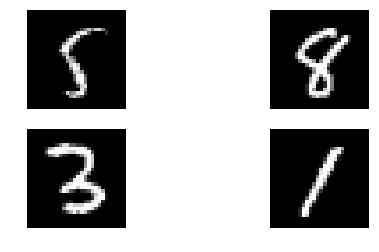

In [12]:
n_images = 4
offset = random.randint(0, 10000)
actual_labels = mnist.test.images[offset:offset + n_images]
predictions = list(model.predict(input_fn))[offset: offset + n_images]

# Display
f = plt.figure(figsize=(8,4))
for i in range(n_images):
    sp = f.add_subplot(2, 2, i+1)
    sp.axis('Off')
    plt.imshow(np.reshape(actual_labels[i], [28, 28]), cmap='gray')
print('Model predictions are ' ,predictions[:2])
print('Model predictions are ' ,predictions[2:4])